# Init

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
with open('pickle/df_target.p', 'rb') as file:
    df_target = pickle.load(file)
df_target.head()

,text,target
0,programa treinamento jornalismo agroindústria ...,10
1,ofício enviado sergio presidente michel esquiv...,6
2,governador sérgio cabral transferido complexo ...,6
3,aplausos federal sergio responsável operação i...,6
4,executivo empreiteira odebrecht afirmou acordo...,6


In [3]:
X = df_target.drop(columns=['target'])
y = df_target['target']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
tfidf = TfidfVectorizer(
    strip_accents='ascii',
    min_df = 10,
    max_features = 10000
)

tfidf_matrix = tfidf.fit_transform(x_train['text'])
x_train_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

tfidf_matrix = tfidf.transform(x_test['text'])
x_test_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

with open('pickle/tfidf.p', 'wb') as file:
    pickle.dump(tfidf, file)

In [6]:
scaler = StandardScaler()
x_train_tfidf = scaler.fit_transform(x_train_tfidf)
x_test_tfidf = scaler.transform(x_test_tfidf)

# Classifier

In [7]:
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
}

log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train_tfidf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10]}, verbose=1)

In [8]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 5}


In [9]:
model = grid_search.best_estimator_

In [10]:
with open('pickle/model_classifier.p', 'wb') as file:
    pickle.dump(model, file)

# Analysis

In [12]:
y_pred = model.predict(x_test_tfidf)
y_prob = model.predict_proba(x_test_tfidf)

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.33      0.34       159
           1       0.56      0.62      0.59       337
           2       0.24      0.25      0.24       104
           3       0.45      0.47      0.46       237
           4       0.42      0.52      0.47       213
           5       0.55      0.52      0.54       302
           6       0.35      0.33      0.34       145
           7       0.42      0.36      0.39       170
           8       0.31      0.28      0.29       120
           9       0.42      0.36      0.39       219

    accuracy                           0.44      2006
   macro avg       0.41      0.40      0.40      2006
weighted avg       0.44      0.44      0.44      2006



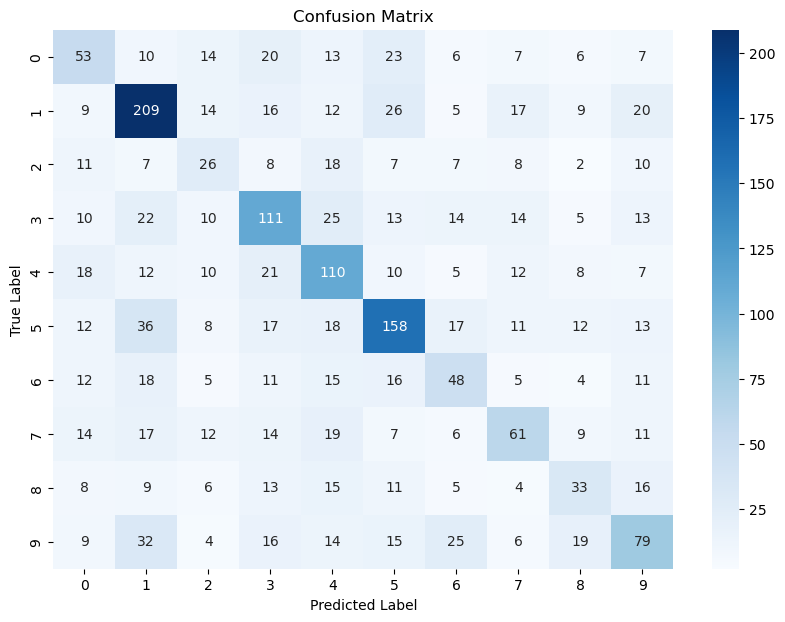

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

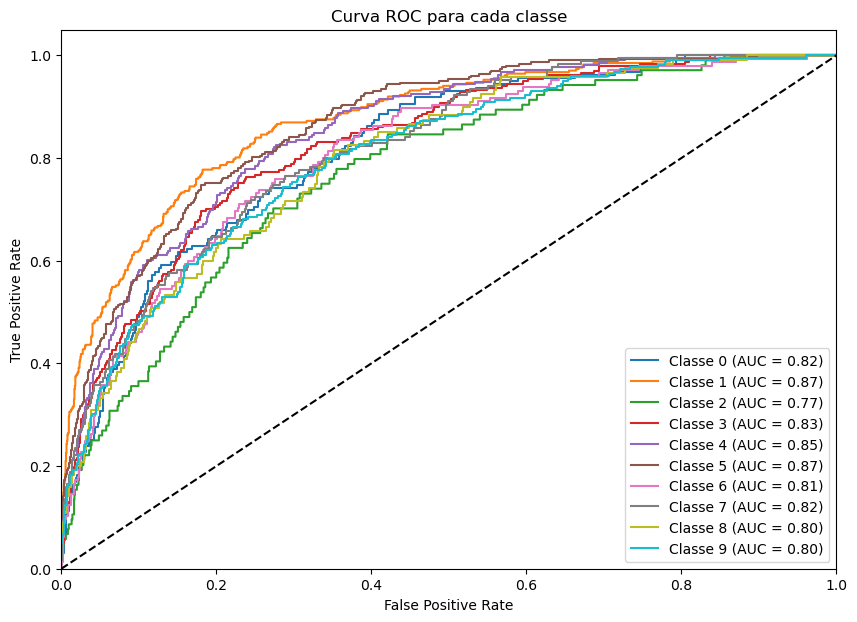

In [15]:
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
roc_auc = dict()
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotando a Curva ROC
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para cada classe')
plt.legend(loc='lower right')
plt.show()